In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix, lil_matrix
from scipy import spatial
from scipy import stats

%matplotlib inline

In [3]:
#importing dataset
dataset= pd.read_csv("data.csv", encoding="ISO-8859-1")

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
dataset.count()

InvoiceNo      541909
StockCode      541909
Description    540455
Quantity       541909
InvoiceDate    541909
UnitPrice      541909
CustomerID     406829
Country        541909
dtype: int64

In [9]:
dataset.count()

InvoiceNo      406829
StockCode      406829
Description    406829
Quantity       406829
InvoiceDate    406829
UnitPrice      406829
CustomerID     406829
Country        406829
dtype: int64

In [10]:
#removing where customerID is null
dataset=dataset[pd.notnull(dataset['CustomerID'])]
#date format
dataset.InvoiceDate = pd.to_datetime(dataset.InvoiceDate, format="%m/%d/%Y %H:%M")

c:\users\walaw\appdata\local\programs\python\python38\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [11]:
dataset = dataset[dataset["InvoiceNo"].astype(str).str[0] != "C"]
dataset = dataset[dataset["InvoiceNo"].astype(str).str[0] != "A"]
dataset = dataset[dataset["Quantity"] > 0 ]
#Z-score Normalization
dataset = dataset[ np.abs((dataset['UnitPrice']-dataset['UnitPrice'].mean())/dataset['UnitPrice'].std())<=1]
dataset = dataset[ np.abs((dataset['Quantity']-dataset['Quantity'].mean())/dataset['Quantity'].std())<=1]
dataset.describe()

,Quantity,UnitPrice,CustomerID
count,394884.000000,394884.000000,394884.000000
mean,10.498914,2.826652,15295.252613
std,17.463665,2.830359,1711.717290
min,1.000000,0.000000,12347.000000
25%,2.000000,1.250000,13969.000000
50%,5.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,192.000000,25.000000,18287.000000


In [12]:
#Revenue Column for further visualizations
dataset['Revenue'] = dataset['Quantity']*dataset['UnitPrice']

dataset['Date'] = dataset['InvoiceDate'].dt.date
dataset['Day'] = dataset['InvoiceDate'].dt.day
dataset['Month'] = dataset['InvoiceDate'].dt.month
dataset['Year'] = dataset['InvoiceDate'].dt.year
dataset['Hour'] = dataset['InvoiceDate'].dt.hour
dataset['Week'] = dataset['InvoiceDate'].dt.week
dataset['Minute'] = dataset['InvoiceDate'].dt.minute

In [214]:
sales = dataset[['Year', 'Month', 'Revenue']].groupby(['Year', 'Month']).sum().reset_index()

In [216]:
sales['Day']=1
sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])

In [218]:
sales=sales.drop(["Year","Month","Day"],axis=1)


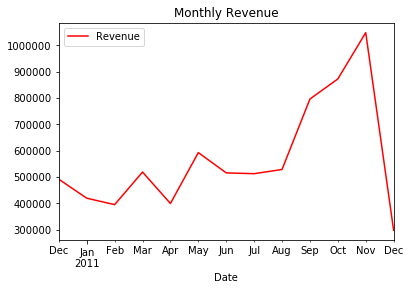

In [221]:
sales.plot(x='Date',y='Revenue', title='Monthly Revenue', color='Red')

In [203]:
#top countries Contributing to Sales
sales_top = dataset[['Revenue', 'Country']].groupby(['Country']).sum().reset_index().sort_values(by='Revenue', ascending=False)['Country'][1:7]

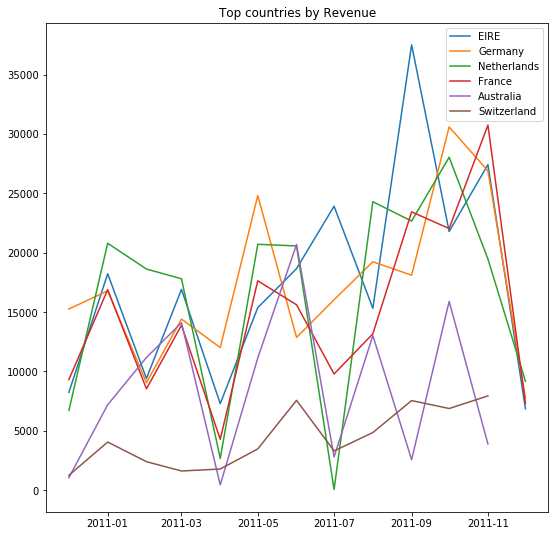

In [252]:
fig, ax = plt.subplots(figsize=(9, 9))
for c in sales_top:
    sales = dataset[dataset['Country'] == c]
    sales = sales[['Year', 'Month', 'Revenue']].groupby(['Year', 'Month']).sum().reset_index()
    sales['Day'] = 1
    sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])
    ax.plot(sales['Date'],sales['Revenue'], label=c)
    ax.legend()
    ax.set_title("Top countries by Revenue")
    

In [99]:
Country_UK=dataset[dataset.Country == "United Kingdom"]

In [100]:
Country_UK= dataset[['StockCode','Revenue']].groupby(['StockCode']).sum().sort_values(by='Revenue', ascending=False).reset_index()        
Country_UK = Country_UK.head(10)

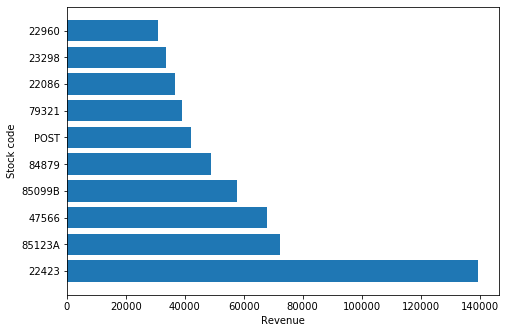

In [101]:
#Plotting Revenue for each individual products
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(Country_UK['StockCode'],Country_UK['Revenue'])
ax.set_ylabel('Stock code')        
ax.set_xlabel('Revenue')
plt.show()

In [283]:
Country_UK = Country_UK.head(10)
Country_UK

,StockCode,Revenue
0,22423,139614.55
1,85123A,72148.58
2,47566,68014.33
3,85099B,57668.48
4,84879,48796.74
5,POST,42253.27
6,79321,39148.11
7,22086,36561.23
8,23298,33700.55
9,22960,30737.97


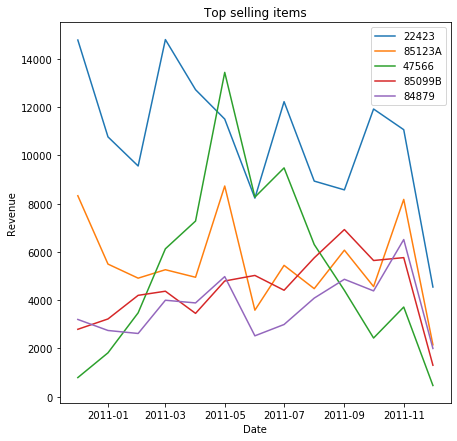

In [105]:
#Visualizing top selling items and how they contributed to the revenue every month
fig, ax = plt.subplots(figsize=(7, 7))
Global = dataset[['StockCode','Revenue']].groupby(['StockCode']).sum().sort_values(by='Revenue', ascending=False).reset_index()['StockCode'][0:5]  


for c in Global:
    monthly_revenue = dataset[dataset['StockCode'] == c]
    monthly_revenue = monthly_revenue[['Year', 'Month', 'Revenue']].groupby(['Year', 'Month']).sum().reset_index()
    monthly_revenue['Day'] = 1
    monthly_revenue['Date'] = pd.to_datetime(monthly_revenue[['Year', 'Month', 'Day']])
    ax.plot(monthly_revenue['Date'],monthly_revenue['Revenue'], label=c)
    ax.set_ylabel('Revenue')        
    ax.set_xlabel('Date')
    ax.legend()
    ax.set_title("Top selling items")


In [329]:
#Top items with maximum number of sales
Item= dataset[['InvoiceNo','StockCode','Description']].groupby(['StockCode','Description']).count().sort_values(by='InvoiceNo', ascending=False).reset_index()
Item=Item.head(7)

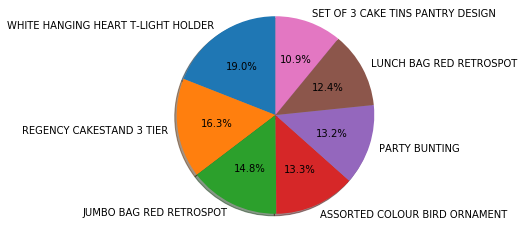

In [330]:
fig1, ax1 = plt.subplots()
ax1.pie(Item['InvoiceNo'], labels=Item['Description'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.show()

In [106]:
#Top revenue contributors
Customer = dataset[['CustomerID','Revenue']].groupby(['CustomerID']).sum().sort_values(by='Revenue', ascending=False).reset_index()
Customer=Customer.head(10)
Customer['CustomerID']=Customer['CustomerID'].astype(str)


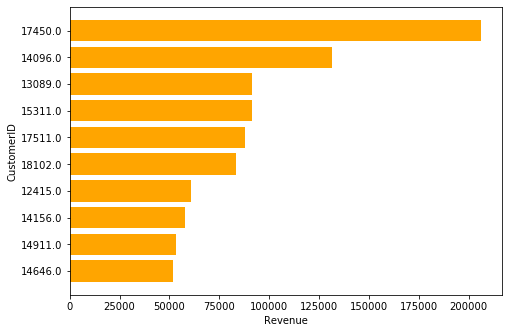

In [108]:
#Top customers 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(Customer['CustomerID'], sorted(Customer['Revenue']), color='orange')
ax.set_ylabel('CustomerID')        
ax.set_xlabel('Revenue')
plt.show()

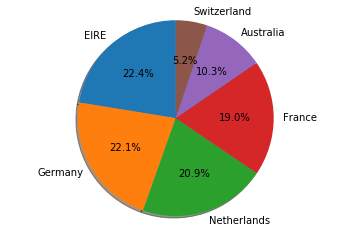

In [96]:
#Top 7 countries and how they contribute
Country= dataset[['Revenue','Country']].groupby(['Country']).sum().sort_values(by='Revenue', ascending=False).reset_index()
Country= Country[1:7]
fig1, ax1 = plt.subplots()
ax1.pie(Country['Revenue'], labels=Country['Country'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.show()

<ipython-input-109-23df13d0755f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['StockCode']=data['StockCode'].astype(str)
<ipython-input-109-23df13d0755f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CustomerID']=data['CustomerID'].astype(str)


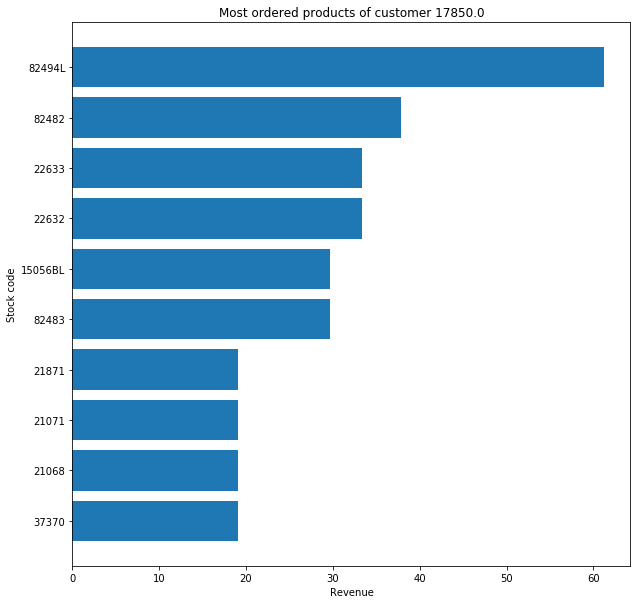

In [109]:
#Most Ordered Products for Customer ID 17850
data=dataset[0:300]
data['StockCode']=data['StockCode'].astype(str)
data['CustomerID']=data['CustomerID'].astype(str)
def customer_record(customer_id):
    c_data = data[data['CustomerID'] == customer_id ]
    most_ordered = c_data[['StockCode', 'Revenue']].groupby(['StockCode']).sum().sort_values(by='Revenue', ascending=True).reset_index()
    most_ordered = most_ordered[0:10]
    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    ax.barh(most_ordered['StockCode'], most_ordered['Revenue'])
    ax.set_ylabel('Stock code')        
    ax.set_xlabel('Revenue')     
    ax.set_title('Most ordered products of customer ' + str(customer_id))    
    
customer_record(customer_id = '17850.0')

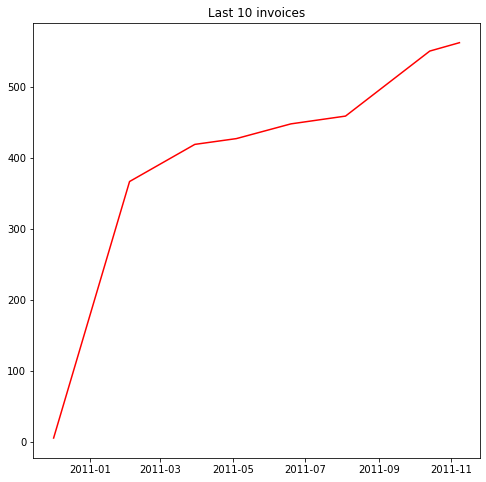

In [111]:
#Last 10 orders of Customer ID 13047
data1=dataset
data1['CustomerID']=data1['CustomerID'].astype(str)

def customer_record1(customer_id):
    c_data = data1[data1['CustomerID'] == customer_id ]
    
    last_inv = c_data[['InvoiceNo', 'Revenue', 'Date']].groupby(['Date']).sum().sort_values(by='Revenue').reset_index()
    #print(last_inv)

    fig, ax = plt.subplots(1,1, figsize=(8, 8))
    ax.plot(sorted(last_inv['Date']) , last_inv['Revenue'], color='red')
    ax.set_title('Last 10 invoices') 
    
customer_record1(customer_id = '13047.0')
